# Supervisé : Classification  

# Classification des produits BestSeller ou non (SVM, KNN, Logistic regression)


In [42]:
#  Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pyodbc

In [43]:
# Connexion au Data Warehouse
conn = pyodbc.connect(
    'DRIVER={SQL Server};SERVER=localhost;DATABASE=SuplyChain_DataWarehouse;Trusted_Connection=yes;'
)
query = """
SELECT 
    fs.Product_PK,
    SUM(fs.Quantite) AS TotalQuantity,
    cat.Category AS ProductCategory,
    b.brandname AS Brand,
    shop.shopname AS Shop,
    d.Year, d.Month,
    DATEDIFF(DAY, prod.ProductionStartDate_PK, prod.ProductionEndDate_PK) AS ProductionDuration,
    (
        SELECT COUNT(*) 
        FROM Fact_Dosage fd 
        WHERE fd.Prod_FK = p.Product_PK
    ) AS NbMaterials
FROM Fact_Sales fs
JOIN Dim_Product p ON fs.Product_PK = p.Product_PK
JOIN Dim_Category cat ON p.Category_FK = cat.Category_PK
JOIN Dim_Brand b ON p.Brand_FK = b.Brand_PK
JOIN Dim_Shop shop ON fs.Shop_PK = shop.Shop_PK
JOIN Dim_Date d ON fs.Date_FK = d.Date_PK
LEFT JOIN fact_production prod ON prod.Product_PK = fs.Product_PK
GROUP BY 
    fs.Product_PK, cat.Category, b.brandname, shop.shopname, d.Year, d.Month,
    prod.ProductionStartDate_PK, prod.ProductionEndDate_PK, p.Product_PK
"""
df = pd.read_sql(query, conn)
conn.close()

C:\Users\user\AppData\Local\Temp\ipykernel_21912\1182364240.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [44]:
#  Nettoyage et cible
df.fillna({'ProductionDuration': 0, 'NbMaterials': 0}, inplace=True)
threshold = df['TotalQuantity'].mean()
df['BestSeller'] = (df['TotalQuantity'] > threshold).astype(int)
X = df.drop(columns=['Product_PK', 'TotalQuantity', 'BestSeller'])
y = df['BestSeller']

In [45]:
#  Encodage One-Hot & Normalisation
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded_cat = encoder.fit_transform(X[cat_cols])
scaler = StandardScaler()
X_scaled_num = scaler.fit_transform(X[num_cols])
X_final = np.concatenate([X_scaled_num, X_encoded_cat], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [46]:
#  Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("\n Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


 Logistic Regression
Accuracy: 0.9230769230769231
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       293
           1       0.89      0.91      0.90       188

    accuracy                           0.92       481
   macro avg       0.92      0.92      0.92       481
weighted avg       0.92      0.92      0.92       481



In [47]:
#  KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("\n KNN")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))



 KNN
Accuracy: 0.9896049896049897


In [48]:
#  SVM (linear & sigmoid)
kernels = ['linear', 'sigmoid']
for kernel in kernels:
    print(f"\n SVM avec kernel = '{kernel}'")
    svm_model = SVC(kernel=kernel, C=1, gamma='scale')
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred_svm))
    print(classification_report(y_test, y_pred_svm))


 SVM avec kernel = 'linear'
Accuracy: 0.9501039501039501
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       293
           1       0.89      0.99      0.94       188

    accuracy                           0.95       481
   macro avg       0.94      0.96      0.95       481
weighted avg       0.95      0.95      0.95       481


 SVM avec kernel = 'sigmoid'
Accuracy: 0.7027027027027027
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       293
           1       0.60      0.69      0.65       188

    accuracy                           0.70       481
   macro avg       0.69      0.70      0.69       481
weighted avg       0.71      0.70      0.71       481



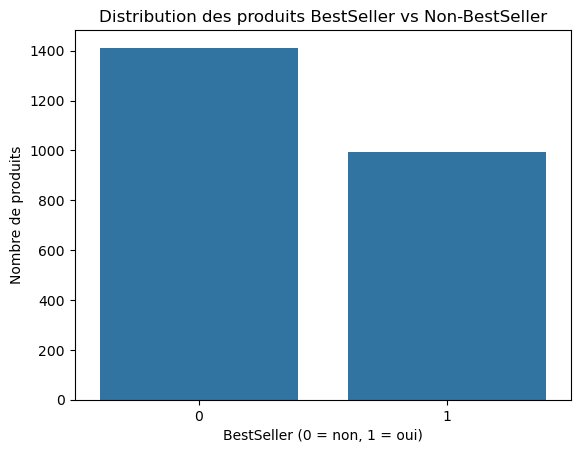

In [49]:
#  Distribution de la cible
sns.countplot(x='BestSeller', data=df)
plt.title('Distribution des produits BestSeller vs Non-BestSeller')
plt.xlabel('BestSeller (0 = non, 1 = oui)')
plt.ylabel('Nombre de produits')
plt.show()